*Creating A Feedforward Neural Network In TensorFlow To Predict Earthquake Magnitudes*


Import libraries

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

The initial dataset was extremely messy, including misaligned columns. Thus, missing data was't filled but rather aligned. Then the new csv "clean_earthquake" was read in using pandas. In doing so, the necessary null values were filled. There was no need for encoding any of the columns since they would not be relevant features for the model.

In [13]:
clean_eq = pd.read_csv('/Users/gerryjr/Desktop/EarthquakeProject/Data/clean_earthquake.csv')

clean_eq['gap'] = clean_eq['gap'].fillna(clean_eq['gap'].median())
clean_eq['dmin'] = clean_eq['dmin'].fillna(clean_eq['dmin'].mean())
clean_eq['rms'] = clean_eq['rms'].fillna(clean_eq['rms'].mean())
clean_eq['depthError'] = clean_eq['depthError'].fillna(clean_eq['depthError'].median())





This is a pre-model visualization to give an idea of how the magnitudes are distributed across their frequency in occurence. It is always good to have a visual before creating the model.

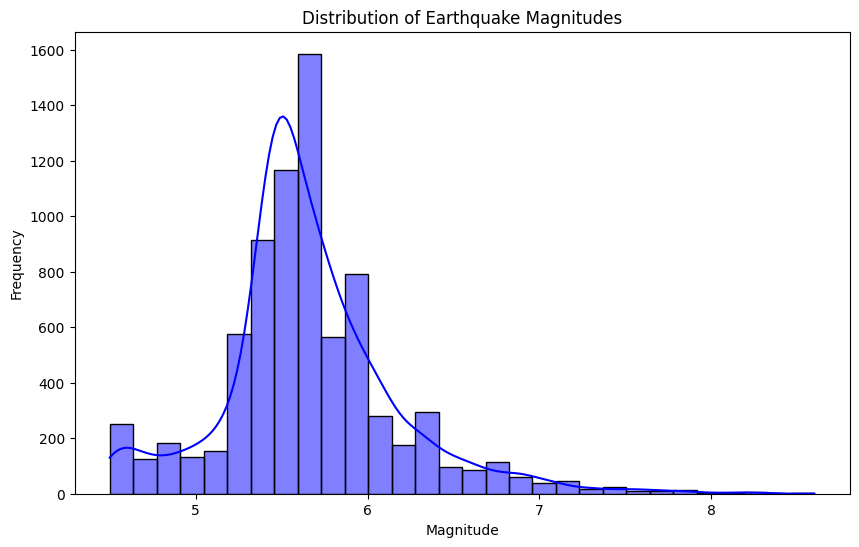

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(clean_eq['mag'], kde=True, bins=30, color='blue')
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()

Below is a geo-spatial visual, created in Tableau, aligning the latitude and longitude coordinates. This provides an interactive visual for the geographical location and color gradient based on magnitude. Each data point is labeled with the corresponding latitude, longitude, time, depth and magnitude.

[View Interactive Tableau Visualization](https://public.tableau.com/views/6H4FCZ8R2?:showVizHome=no)


Now it is time for selecting features and engineering any necessary ones. As mentioned before, portions of data had such severe amounts of null space that they were eliminated completely. Thus, 3 additional features are engineered to aid the model in drawing more information for the magnitude prediction. In particular, the 'depth_error_ratio' is a relationship feature that can provide meaningful information. The final engineered feature is the Gutenberg-Richter relation. After doing some research online, it became clear that this relation in geology, takes the magnitude of earthquakes and the number of earthquakes of that magnitude or greater. After trial and error with feature engineering, this one in particular made a significant difference in the model accuracy.

In [15]:
#Feature Engineering
clean_eq['depth_squared'] = clean_eq['depth'] ** 2
clean_eq['depth_error_ratio'] = clean_eq['depthError'] / clean_eq['depth']
clean_eq['depth_error_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
clean_eq['depth_error_ratio'].fillna(clean_eq['depth_error_ratio'].median(), inplace=True)

#Gutenberg-Richter Relationship
clean_eq['energy_release'] = 10 ** (1.5 *clean_eq['mag'])
clean_eq['energy_release'] = np.clip(clean_eq['energy_release'], None, 1e10)  # Adjust threshold as needed

/var/folders/_2/d_jf9l7x2rl2fp7yfmdp4c100000gn/T/ipykernel_6717/222454344.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_eq['depth_error_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/_2/d_jf9l7x2rl2fp7yfmdp4c100000gn/T/ipykernel_6717/222454344.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

Select the features for the model to learn from. Standard features such as, depth, rms and gap or entered along with the engineered features mentioned in the previous markdown. Obviously, the target for this scenario is magnitude('mag'). 

In [16]:
# Features and Targets
X = clean_eq[['latitude',
            'longitude', 
            'depth', 
            'gap', 
            'dmin', 
            'rms', 
            'depthError', 
            'depth_squared', 
            'depth_error_ratio', 
            'energy_release'
            ]]
y = clean_eq['mag']  # Target variable (magnitude)



Before splitting the training and testing, it is important to scale the features.

The train/test split is initiated with a testing size of 20%.

In [17]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Next, it is time to assemble the Feedforward Neural Network. Keep in mind that Sequential, Dense and Dropout were imported from tensorflow.keras.layer in the first cell and there are 4 layers to this model. When this was initially created, there was overfitting ("the model accuracy being 100%") which is not a good thing. That means the model is relying too heavily on particular neurons or simply memorizing portions of the trained data. The goal is to have the model recognize patterns so it can make accurate predictions with future data, not memorize the current data. Therefore, a Dropout function is placed between each layer where it drops 20% of the neurons in each training step. This forces the model to learn, not memorize. The final layer has one neuron since it is the goal to predict one target.

In [18]:
# Build Feedforward Neural Network (FNN)
fnn = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Single output neuron for magnitude
])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now that the model is built, it is time to compile, train, evaluate and predict. The compiler tells the neural network how to learn the data. In this case the "adam" optimizer argument is common and dynamically updates the weights through training. The loss argument ('mse') measures how far off the predictions are from the real values. The metrics argument ('mae') calculates the absolute distance between predictions and true values. 

After compiling, the model gets trained with 50 epochs (iterations).

Finally, it is time to predict the tested X values. In doing so, we print the first 10 predicted values along with the first 10 actual values.

In [19]:
# Compile the FNN
fnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the FNN
history = fnn.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)

# Evaluate the model
loss, mae = fnn.evaluate(X_test, y_test)
print(f"Loss: {loss}, Mean Absolute Error: {mae}")

# Make predictions for the entire test set
pred = fnn.predict(X_test)

# Print the first 10 predictions and true values for verification
print("First 10 Predictions:", pred[:10].flatten())
print("First 10 True Values:", y_test[:10].values)


Epoch 1/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.6496 - mae: 2.1793 - val_loss: 0.3381 - val_mae: 0.4563
Epoch 2/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6406 - mae: 0.6354 - val_loss: 0.1744 - val_mae: 0.3272
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4050 - mae: 0.5085 - val_loss: 0.1398 - val_mae: 0.2914
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3467 - mae: 0.4464 - val_loss: 0.0997 - val_mae: 0.1955
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2538 - mae: 0.3921 - val_loss: 0.0736 - val_mae: 0.2100
Epoch 6/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1943 - mae: 0.3415 - val_loss: 0.0657 - val_mae: 0.1510
Epoch 7/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1882 - mae: 0.3181 - val_loss: 0.0720 - val_mae: 0.1458
Epoch 8/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1259 - mae: 0.2707 - val_loss: 0.0752 - val_mae: 0.2216
Epoch 9/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

^^You will notice, as the above cell ran, the "loss" dropped each iteration which is good. This indicates the model became more accurate each iteration. The output also indicates a fairly good prediction.

Now let's display the results of the MSE and MAE:

In [20]:
# Calculate metrics for the entire test set
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 0.05092520591508539
Mean Squared Error (MSE): 0.011823402039738407





Now prepare the data for a visualization in Tableau, specifically the relationship between depth and error.

In [21]:
# Prepare the data for Tableau visualization
X_test = pd.DataFrame(X_test, columns=[['latitude',
            'longitude', 
            'depth', 
            'gap', 
            'dmin', 
            'rms', 
            'depthError', 
            'depth_squared', 
            'depth_error_ratio', 
            'energy_release'
            ]])
y_test = y_test.reset_index(drop=True)
pred_series = pd.Series(pred.flatten(), name="Predicted_Magnitude", index=y_test.index)

# Add True Magnitude and Predicted Magnitude to the DataFrame
X_test['True_Magnitude'] = y_test
X_test['Predicted_Magnitude'] = pred_series

After preparing the data, it is brought into Tableau and visualized in a density plot. This plot indicates that error is lower for shallower depths and more innacurate as they become deeper. This is somewhat expected. This goes back to my previous point on having more reliable data for more accuracy.

In [22]:

# Create a DataFrame with true and predicted values
results_df = pd.DataFrame({
    'True Magnitude': y_test.values.flatten(),
    'Predicted Magnitude': pred.flatten()})
# Save to CSV
results_df.to_csv('true_vs_predicted.csv', index=False)

print("CSV file 'true_vs_predicted.csv' created successfully!")


CSV file 'true_vs_predicted.csv' created successfully!


Having saved the csv, the below visualization is a scatter plot of the true and predicted magnitudes

[View Tableau Visualization](https://public.tableau.com/views/TrueVSPredictedMagnitudes/TrueVSPredictedMagnitudes)
